# Rain Forecasting Using Liquid Neural Networks
José Ferreira and Rúben Antunes

## Import required libraries

In [11]:
# Library for operating system functionalities
import os
# Library for numerical operations
import numpy as np
# Library for data manipulation and analysis
import pandas as pd
# Library for interactive data visualization
import matplotlib.pyplot as plt
# Libraries for Deep Learning models
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
# Library for image processing and manipulation
from PIL import Image
# Library for reading and writing Excel files
from openpyxl import load_workbook
# Library for reading and writing JSON files
import json
# Library for date and time operations
from datetime import datetime, timedelta

## Set Constants and Hyperparameters

In [12]:
# Reset all state generated by keras
keras.backend.clear_session()

# Constants
DatasetPath = 'datasets/precipitation_dataset/'
StationsIDs = np.array([1200554, 1200558, 1200562, 1200570, 1200571, 1200575, 1210683, 1210702, 1210707, 1210718, 1210734, 1210770, 1240566, 1240610, 1240675, 1240903, 6212124, 7240919])
PrecipitationClasses = ['Verde', 'Verde Claro', 'Amarelo']

# Hyperparameters
WMethod = 1 # Weights initialization method (1 to 15, 1 = PSJ)
NLayer_ini = 1 # Number of initial hidden layers
NLayermax = 2 #show -1 HLayers than this number
deltaNLayer = 1 # Delta increment for hidden layers
NEpochs = 100 # Epochs number alterado de 11 para 100
n_folds = 10  # Folders number. Should be higher than 2
N_neuronio = 64 # Neurons number
Batch_len = 5   # Batch Size number

Xinput = 10000 # Number of inputs
Youtput = 3 # Number of outputs
NSamples = 16 # Number of samples for test validation

## Define auxiliary functions

In [13]:
def count_occurrences_of_each_value(arr):
    unique, counts = np.unique(arr, return_counts=True)
    return dict(zip(unique, counts))

def resize_image(path, size):
    # Open the image file
    original_image = Image.open(path)
    # Resize the image
    resized_image = original_image.resize((size, size))
    # Return the resized image
    return resized_image

## Data Treatment

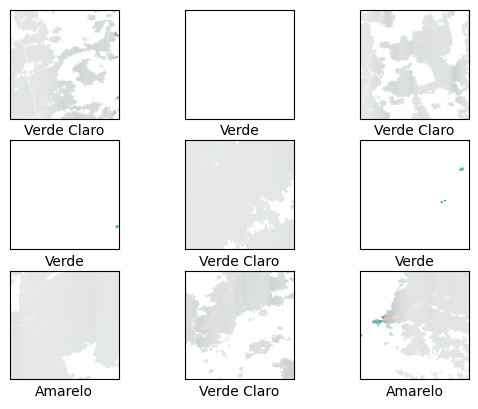

Number of samples of each class used in training:


{np.float64(0.0): np.int64(14),
 np.float64(1.0): np.int64(12),
 np.float64(2.0): np.int64(13)}

Number of samples of each class used in testing:


{np.float64(0.0): np.int64(6),
 np.float64(1.0): np.int64(8),
 np.float64(2.0): np.int64(4)}

In [14]:
image_size = 100 # Image size = 100x100
time_difference = 1 # Time difference between the image and the precipitation value in hours
limit_dictionary = {key: 20 for key in range(len(PrecipitationClasses))} # Limit how many samples of each precipitation category (default = 20)
counter_dictionary = {key: 0 for key in range(len(PrecipitationClasses))} # Counter for samples of each precipitation category

data_array = np.empty(0) # Initialize array to store precipitation values
images_array = np.empty((0, image_size, image_size, 4)) # Initialize array to store images

# Shuffle stations IDs to avoid bias
stations_ids = StationsIDs
np.random.shuffle(stations_ids)

for station_id in stations_ids:
    station_json = DatasetPath + 'values/' + str(station_id) + '.json'
    with open(station_json) as f:
        # Load the JSON data
        json_data = json.load(f)
    f.close()
    for date, hours in json_data.items():
        for hour in hours:
            image_hour = datetime.strptime(hour, "%H:%M")
            # Subtract one hour
            image_hour = image_hour - timedelta(hours=time_difference)
            # Convert back to string
            image_hour = image_hour.strftime("%H:%M")
            image_name = date + 'T' + image_hour.replace(':', '') + '.png'
            image_path = DatasetPath + 'images/' + str(station_id) + '/' + date + '/' + image_name
            precipitation_value = json_data[date][hour]

            if not os.path.exists(image_path):
                continue # Skip the current iteration if the image doesn't exist
            if counter_dictionary[precipitation_value] < limit_dictionary[precipitation_value]:
                counter_dictionary[precipitation_value] += 1
                data_array = np.append(data_array, precipitation_value)
                image = resize_image(image_path, image_size)
                image_array = np.array(image)
                image.close()
                images_array = np.append(images_array, [image_array], axis=0)

                """# Abordagem 3: Duplicar imagens da classe(s) minoritária(s) (classe 1 e 2)
                if value == 2:
                    for _ in range(177):  # Ajustar o número de duplicações para balancear com a classe 0
                        data_array = np.append(data_array, value)
                        images_array = np.append(images_array, [img_np], axis=0)
                elif value == 1:
                    for _ in range(50):  # Ajustar o número de duplicações para balancear com a classe 0
                        data_array = np.append(data_array, value)
                        images_array = np.append(images_array, [img_np], axis=0)"""

# Shuffle dataset to avoid bias
random_order = np.random.permutation(len(data_array))
images_array, data_array = images_array[random_order], data_array[random_order]

# Split the dataset into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(images_array, data_array, test_size=0.3, random_state=2)

# Normalize images pixels
train_images = keras.utils.normalize(train_images, axis=1)
test_images = keras.utils.normalize(test_images, axis=1)

# Visualize sample of training images in a grid
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i])
    plt.xlabel(PrecipitationClasses[int(train_labels[i])])
plt.show()

print("Number of samples of each class used in training:")
display(count_occurrences_of_each_value(train_labels))
print("Number of samples of each class used in testing:")
display(count_occurrences_of_each_value(test_labels))

# Initialize inputs tensors/arrays for training and testing
x_train = train_images[:6*NSamples, :100, :100]
x_test = test_images[:NSamples, :100, :100]

# Initialize ouputs tensors/arrays for training and testing
y_train = train_labels[:6*NSamples]
y_test = test_labels[:NSamples]


## Model Training (CNN)

C:\Users\antun\Desktop\UNI\PI\Experiments\Network-training-23-24\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 100, 100, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,624 (260.25 KB)

 Trainable params: 66,240 (258.75 KB)

 Non-trainable params: 384 (1.50 KB)

Weight initialization - Start
Method PSJ
[[[0.00270896 0.10246737 0.09412305 0.10376785]
  [0.0043263  0.1087278  0.10355112 0.11453133]
  [0.00350484 0.1065917  0.09837955 0.11011786]
  ...
  [0.06357544 0.03437965 0.02917487 0.03539713]
  [0.04065206 0.03406271 0.02858977 0.03616401]
  [0.02885451 0.03411573 0.02858928 0.03648795]]

 [[0.06471406 0.11617572 0.09933605 0.08944216]
  [0.05545529 0.11212146 0.09637093 0.11457364]
  [0.05082025 0.11188048 0.09650231 0.10770386]
  ...
  [0.04330501 0.04667242 0.0417732  0.03864583]
  [0.03821202 0.04560687 0.03380516 0.04129905]
  [0.05112363 0.04487177 0.02442394 0.03673909]]

 [[0.04003242 0.11281589 0.09659656 0.10043258]
  [0.05152229 0.11057052 0.09223265 0.10978566]
  [0.0570789  0.10821536 0.08988985 0.11184359]
  ...
  [0.         0.04443441 0.03959671 0.04681268]
  [0.00334793 0.0418925  0.03509073 0.04320765]
  [0.00499409 0.04382488 0.03628179 0.03799482]]

 ...

 [[0.         0.06814851 0.06495113 0.07936412]
  [0.         0.0

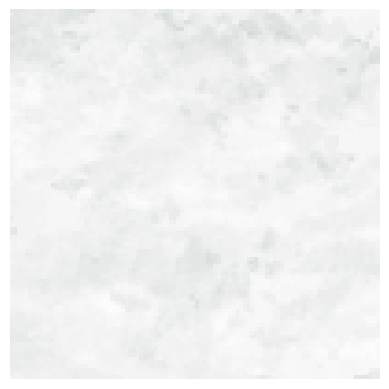

(1, 40000)


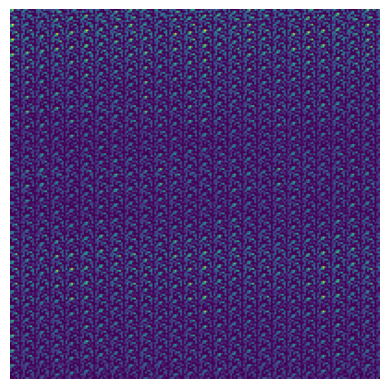

[[-0.00513038 -0.00765988  0.00195702 ... -0.00218648 -0.00435806
   0.00248053]
 [-0.00207552 -0.02107427 -0.02385884 ...  0.00293439  0.00621453
  -0.00471469]
 [ 0.02023782  0.02674714 -0.02280895 ... -0.00240002  0.00500659
  -0.00868497]
 ...
 [-0.00207552 -0.02107427 -0.02385884 ...  0.00293439  0.00621453
  -0.00471469]
 [ 0.02023782  0.02674714 -0.02280895 ... -0.00240002  0.00500659
  -0.00868497]
 [-0.00513038 -0.00765988  0.00195702 ... -0.00218648 -0.00435806
   0.00248053]]
(64, 40000)
Weight initialization - End

Hidden Layer =  1

Fold 1

Weights loaded
Epoch 1/10


C:\Users\antun\Desktop\UNI\PI\Experiments\Network-training-23-24\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamax', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\antun\Desktop\UNI\PI\Experiments\Network-training-23-24\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8129 - loss: 0.3061 - precision: 0.8129 - recall: 0.8129
Epoch 1: val_accuracy improved from -inf to 0.93750, saving model to model_weights_by_hour/hour_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 329ms/step - accuracy: 0.8223 - loss: 0.2912 - precision: 0.8223 - recall: 0.8223 - val_accuracy: 0.9375 - val_loss: 0.2927 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9343 - loss: 0.3960 - precision: 0.9343 - recall: 0.9343
Epoch 2: val_accuracy did not improve from 0.93750
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.9331 - loss: 0.3860 - precision: 0.9331 - recall: 0.9331 - val_accuracy: 0.8750 - val_loss: 0.8572 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.8716 - loss: 0.7205 - precision: 0.8658 - recall: 0.8034
Epoch 3: val_accuracy did not improve from 0.93750
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 236m

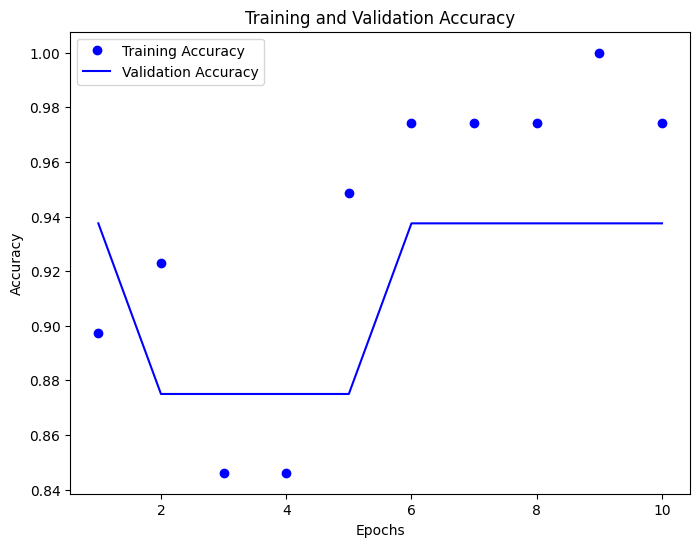

   Accuracy Train[ 10 ] = 0.9744  |  Max Accuracy Train[ 9 ] =  1.0000         |  Accuracy Train[ 1 ] =  0.8974
   Accuracy Test[ 10 ] = 0.9375   |  Validation Accuracy Test[ 9 ] =  0.9375   |  Max Valid. Accuracy Test[ 1 ] =  0.9375

Fold 2

Weights loaded
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9864 - loss: 0.1770 - precision: 0.9864 - recall: 0.9864
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to model_weights_by_hour/hour_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 359ms/step - accuracy: 0.9823 - loss: 0.2114 - precision: 0.9823 - recall: 0.9823 - val_accuracy: 0.8750 - val_loss: 0.5061 - val_precision: 0.9333 - val_recall: 0.8750
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 1.0000 - loss: 0.0176 - precision: 1.0000 - recall: 1.0000
Epoch 2: val_accuracy improved from 0.87500 to 0.93750, saving model to model_weights_by_hour/hour_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 1.0000 - 

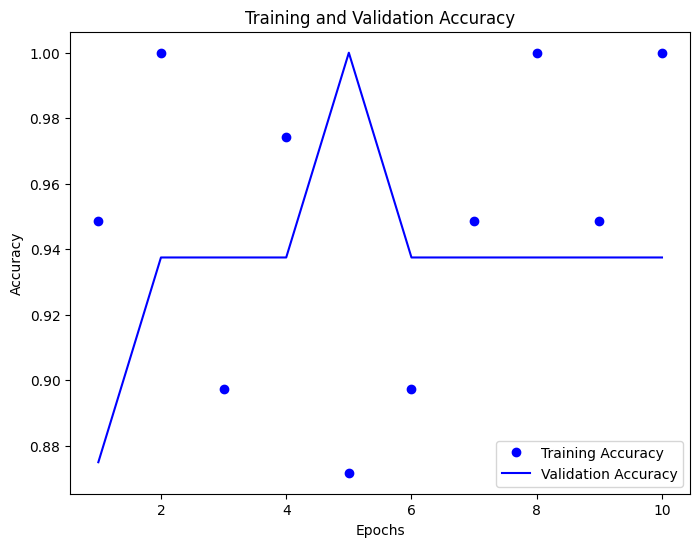

   Accuracy Train[ 10 ] = 1.0000  |  Max Accuracy Train[ 2 ] =  1.0000         |  Accuracy Train[ 5 ] =  0.8718
   Accuracy Test[ 10 ] = 0.9375   |  Validation Accuracy Test[ 2 ] =  0.9375   |  Max Valid. Accuracy Test[ 5 ] =  1.0000


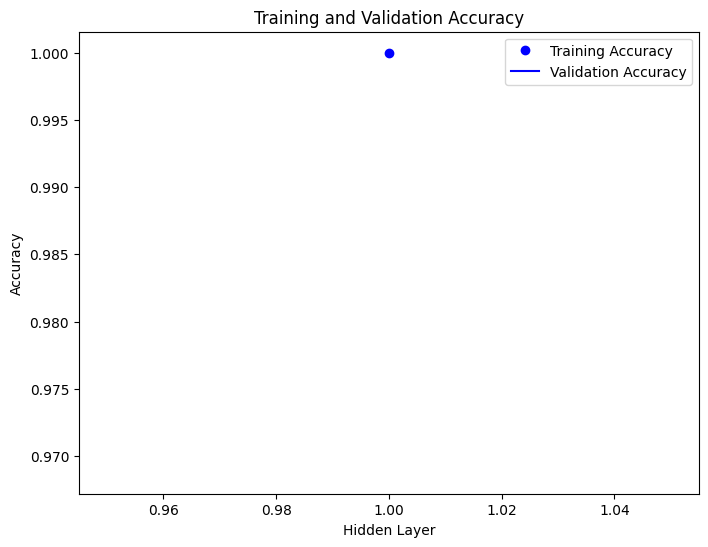



Average of Train Accuracy = 2 folds: 100.00%


Average of Validation Accuracy = 2 folds: 96.88%

train_accuracies_ [np.float64(1.0)]
losses_ [np.float64(0.01855)]
accuracies_ [np.float64(0.96875)]
precisions_ [np.float64(1.0)]
val_precisions_ [np.float64(0.96875)]
recalls_ [np.float64(1.0)]
val_recalls_ [np.float64(0.96875)]



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,560,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,892,875 (30.11 MB)

 Trainable params: 2,630,787 (10.04 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 5,261,576 (20.07 MB)

In [16]:
# Initialize the model outside the loop to allow weight initialization before actual training
def initialize_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last', input_shape=(100,100,4)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
    model.add(keras.layers.Dropout(0.35))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
    model.add(keras.layers.Dropout(0.0035))
    model.add(keras.layers.Flatten(name='flatten'))
    model.summary()
    return model

cnn_model = initialize_model()

# Define the prediction function outside the loop
def predict_with_model(image):
    return cnn_model.predict(image.reshape(1, 100, 100, 4), verbose=0)

# Implement the PSJ method for the 1st Deep Learning layer (João Silva Pereira)
def PSJmethod():
    z=np.zeros((N_neuronio, Xinput*4))     # reshaping here
    for i in range(0, N_neuronio):
        if i < Youtput:
            soma = np.zeros([100,100,4])
            cont = 0
            for n in range(0, len(x_train)):
                if y_train[n] == np.mod(i,Youtput):
                    soma += x_train[n]
                    cont += 1
            soma /= cont

            # Call the prediction function inside the loop
            soma_r = predict_with_model(soma)

            if i == 2:
                #print(soma.shape)
                print(soma)
                # Plot the array as an image
                plt.imshow(soma)
                plt.axis('off')  # Disable axis
                plt.show()

                print(soma_r.shape)
                #print(soma)
                # Plot the array as an image
                plt.imshow(soma_r.reshape(200,200))
                plt.axis('off')  # Disable axis
                plt.show()

            soma = tf.reshape(soma_r, [100*100*4])      # reshaping here
            s = np.array(soma, dtype=np.complex128)  # 64-bit complex numbers (higher precision)
            s = np.fft.fft(s)
            s = np.cos(np.angle(s))+np.sin(np.angle(s))*1j
            s = np.fft.ifft(s)
            z[i] = s.real
        else:
            z[i] = z[np.mod(i,Youtput)]
    return z

# Implement the PSJ method for the other Deep Learning layers (João Silva Pereira)
def iniL2(N_neur, inp):
    LastLayerANN=np.zeros((N_neur, inp))
    for r in range(0,N_neur):
        if np.mod(r,inp)==0:
            for k in range(0,inp):
                for s in range(0,inp):
                    if k==s:
                        if (r+k)<N_neur:
                            LastLayerANN[r+k][s]=1
    return LastLayerANN


# Initialize the seeds within tensorflow for results to be reproducible
# Seeds for NumPy and TensorFlow
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
# Settings for reproducibility (this may affect performance)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Function that initializes the Weights of the Deep Learning Network for 15 different methods
def getWeightInitializer(method):
    match method:
        case 1:
            print("Method PSJ")
            psj = PSJmethod()
            print(psj)
            print(psj.shape)
            return tf.constant_initializer(psj), tf.constant_initializer(iniL2(N_neuronio, N_neuronio)), keras.initializers.Ones()
        case 2:
            print("Method GlorotNormal")
            glorot_normal = keras.initializers.GlorotNormal(seed=seed_value)
            return glorot_normal, glorot_normal, glorot_normal
        case 3:
            print("Method GlorotUniform")
            glorot_uniform = keras.initializers.GlorotUniform(seed=seed_value)
            return glorot_uniform, glorot_uniform, glorot_uniform
        case 4:
            print("Method HeNormal")
            he_normal = keras.initializers.HeNormal(seed=seed_value)
            return he_normal, he_normal, he_normal
        case 5:
            print("Method HeUniform")
            he_uniform = keras.initializers.HeUniform(seed=seed_value)
            return he_uniform, he_uniform, he_uniform
        case 6:
            print("Method LecunNormal")
            lecun_normal = keras.initializers.LecunNormal(seed=seed_value)
            return lecun_normal, lecun_normal, lecun_normal
        case 7:
            print("Method LecunUniform")
            lecun_uniform = keras.initializers.LecunUniform(seed=seed_value)
            return lecun_uniform, lecun_uniform, lecun_uniform
        case 8:
            print("Method Orthogonal")
            orthogonal = keras.initializers.Orthogonal()
            return orthogonal, orthogonal, orthogonal
        case 9:
            print("Method RandomNormal")
            random_normal = keras.initializers.RandomNormal(mean=0., stddev=1.)
            return random_normal, random_normal, random_normal
        case 10:
            print("Method RandomUniform")
            random_uniform = keras.initializers.RandomUniform(minval=0., maxval=1.)
            return random_uniform, random_uniform, random_uniform
        case 11:
            print("Method Identity")
            identity = keras.initializers.Identity()
            return identity, identity, identity
        case 12:
            print("Method TruncatedNormal")
            truncated_normal = keras.initializers.TruncatedNormal(mean=0., stddev=0.5)
            return truncated_normal, truncated_normal, truncated_normal
        case 13:
            print("Method VarianceScaling")
            variance_scaling = keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')
            return variance_scaling, variance_scaling, variance_scaling
        case 14:
            print("Method Zeros")
            zeros = keras.initializers.Zeros()
            return zeros, zeros, zeros
        case 15:
            print("Method Ones")
            ones = keras.initializers.Ones()
            return ones, ones, ones
        case _:
            print("No Method Selected")

# Create 3 initializers that will train the model
print("Weight initialization - Start")
initializer1, initializer2, initializer3 = getWeightInitializer(WMethod)
print("Weight initialization - End")

# Initialize xls writer to store results
xlsFileName = 'Train_method_' + str(WMethod) + ' N' + str(N_neuronio) + " MaxHiddenLayer" + str((NLayermax-1)) + " MaxFolds" + str(n_folds) + " " + datetime.now().strftime("%Y_%m_%d_%H%M%S") + '.xlsx'
writer = pd.ExcelWriter(xlsFileName, engine='openpyxl')

# Create empty arrays
hidden_layers_ =[]
train_accuracies_=[]
losses_=[]
accuracies_=[]
val_losses_=[]
precisions_=[]
val_precisions_=[]
recalls_=[]
val_recalls_=[]

# Start the program for different configurations
try:
    # Configuration of the hidden layers
    for n_HL in range(NLayer_ini, NLayermax, deltaNLayer):
        NLayer=n_HL
        print("")
        print("Hidden Layer = ", NLayer)
        accuracies = []
        train_accuracies = []
        precisions = []
        val_precisions = []
        losses =[]
        val_losses = []
        recalls = []
        val_recalls = []
        # Configuration of the different folds
        for fold in range(0, n_folds):
            fold += 1
            print(f"\nFold {fold}")
            print("")

            x_train_fold = x_train.reshape(-1, 100, 100, 4)
            y_train_fold =  y_train
            x_val_fold = x_test
            y_val_fold = y_test

            y_train_one_hot = keras.utils.to_categorical(y_train_fold, num_classes=Youtput)
            y_val_one_hot = keras.utils.to_categorical(y_val_fold, num_classes=Youtput)

            # Callback to save the Keras model or model weights at some frequency
            model_checkpoint = keras.callbacks.ModelCheckpoint(filepath="model_weights_by_hour/hour_difference_" + str(time_difference) + ".weights.h5", monitor='val_accuracy', save_best_only=True, verbose=1, mode='max', save_weights_only=True)

            # Configuration of the Augmentation method
            datagen = keras.preprocessing.image.ImageDataGenerator(
                rotation_range=5,
                width_shift_range=0.02,
                height_shift_range=0.02,
                shear_range=0.02,
                zoom_range=0,
                fill_mode='nearest'
            )

            # Deep Learning Network configuration
            model = keras.models.Sequential()

            model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',
                            input_shape=(100,100,4)))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
            model.add(keras.layers.Dropout(0.35))
            model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
            model.add(keras.layers.Dropout(0.0035))
            model.add(keras.layers.Flatten(name='flatten'))
            Bias_ini = 'zeros'
            model.add(keras.layers.Dense(N_neuronio, activation='relu', kernel_initializer=initializer1, bias_initializer=Bias_ini))
            # Configuration of the quantity of Hidden Layers
            for f in range(1, NLayer+1):
                model.add(keras.layers.Dense(N_neuronio, activation='relu', kernel_initializer=initializer2, bias_initializer=Bias_ini))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Dense(Youtput, activation='softmax', kernel_initializer=initializer3))

            # Compile Model
            model.compile(optimizer=keras.optimizers.Adamax(learning_rate=0.0055),
                        loss='categorical_crossentropy',
                        metrics=['accuracy', 'precision', 'recall'])

            # Adjust the data generator
            #datagen.fit(x_train_fold)

            #, verbose=0
            weights_dir = "model_weights_by_hour/hour_difference_" + str(time_difference) + ".weights.h5"
            #load best weights
            # Nao realizar este passo para comparação entre metodos de inicialização
            try:
                model.load_weights(weights_dir)
                print("Weights loaded")
            except:
                print("Weights not loaded")

            history = model.fit(datagen.flow(x_train_fold, y_train_one_hot,batch_size=Batch_len),
                                validation_data=(x_val_fold, y_val_one_hot), epochs=NEpochs, callbacks=[model_checkpoint])

            # Gets training and validation accuracy results
            train_accuracy = history.history['accuracy']
            val_accuracy = history.history['val_accuracy']

            # Show results
            epochs = range(1, len(train_accuracy) + 1)

            plt.figure(figsize=(8, 6))
            plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
            plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()

            r=history #necessary, don't touch ;)
            n=np.argmax(r.history['accuracy'])
            n_l=np.argmin(r.history['loss'])
            n_val=np.argmax(r.history['val_accuracy'])
            n_vl=np.argmin(r.history['loss'])
            n_p=np.argmax(r.history['precision'])
            n_vp=np.argmax(r.history['val_precision'])
            n_r=np.argmax(r.history['recall'])
            n_vr=np.argmax(r.history['val_recall'])


            print("   Accuracy Train[",NEpochs,"] = " + "%.4f" % np.round(r.history['accuracy'][NEpochs-1],4), " |  Max Accuracy Train[",n+1,"] = ",\
                    "%.4f" % np.round(r.history['accuracy'][n],4), "        |  Accuracy Train[",n_val+1,"] = ",\
            "%.4f" % np.round(r.history['accuracy'][n_val],4))

            print("   Accuracy Test[",NEpochs,"] = " + "%.4f" % np.round(r.history['val_accuracy'][NEpochs-1],4), "  |  Validation Accuracy Test[",n+1,"] = ",\
                    "%.4f" % np.round(r.history['val_accuracy'][n],4), "  |  Max Valid. Accuracy Test[",n_val+1,"] = ",\
            "%.4f" % np.round(r.history['val_accuracy'][n_val],4))

            train_accuracies.append(np.round(r.history['accuracy'][n],4))
            losses.append(np.round(r.history['loss'][n_l],4))
            accuracies.append(np.round(r.history['val_accuracy'][n_val],4))
            val_losses.append(np.round(r.history['loss'][n_vl],4))
            precisions.append(np.round(r.history['precision'][n_p],4))
            val_precisions.append(np.round(r.history['val_precision'][n_vp],4))
            recalls.append(np.round(r.history['recall'][n_r],4))
            val_recalls.append(np.round(r.history['val_recall'][n_vr],4))

            data = {
                'Epoch' : epochs,
                'Accuracy': np.round(r.history['accuracy'],4),
                'Loss': np.round(r.history['loss'],4),
                'val_accuracy' : np.round(r.history['val_accuracy'],4),
                'val_loss' : np.round(r.history['val_loss'],4),
                'precision': np.round(r.history['precision'],4),
                'val_precision': np.round(r.history['val_precision'],4),
                'recall': np.round(r.history['recall'],4),
                'val_recall': np.round(r.history['val_recall'],4)
            }

            df = pd.DataFrame(data)

            # Save the DataFrame to the Excel sheet
            sheet_name = f'Fold_{fold}'+f'HLayer_{n_HL}'
            df.to_excel(writer, sheet_name=sheet_name, index=False)
            keras.backend.clear_session()

        train_accuracies_.append(np.mean(train_accuracies))
        losses_.append(np.mean(losses))
        accuracies_.append(np.mean(accuracies))
        val_losses_.append(np.mean(val_losses))
        precisions_.append(np.mean(precisions))
        val_precisions_.append(np.mean(val_precisions))
        recalls_.append(np.mean(recalls))
        val_recalls_.append(np.mean(val_recalls))

    # Show last plot for all Hidden Layers
    hidden_layers_ = range(NLayer_ini, NLayermax, deltaNLayer)
    plt.figure(figsize=(8, 6))
    plt.plot(hidden_layers_, train_accuracies_, 'bo', label='Training Accuracy')
    plt.plot(hidden_layers_, accuracies_, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Hidden Layer')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    data = {
            'HiddenLayer' : hidden_layers_,
            'Accuracy': train_accuracies_,
            'loss' : losses_,
            'val_accuracy' : accuracies_,
            'val_loss' : val_losses_,
            'precision' : precisions_,
            'val_precision' : val_precisions_,
            'recall' : recalls_,
            'val_recall' : val_recalls_
        }
    df = pd.DataFrame(data)
    # Save the DataFrame to the Excel sheet
    sheet_name = f'Fold_HL_Average{NLayermax}'
    df.to_excel(writer, sheet_name=sheet_name, index=False)

except KeyboardInterrupt:
    print('\n --- KeyboardInterrupt detected ---')
finally:
    print("")
    mean_Train_accuracy = np.mean(train_accuracies)
    print(f"\nAverage of Train Accuracy = {n_folds} folds: {mean_Train_accuracy * 100:.2f}%")
    print("")
    mean_accuracy = np.mean(accuracies)
    print(f"\nAverage of Validation Accuracy = {n_folds} folds: {mean_accuracy * 100:.2f}%")
    print("")
    print("train_accuracies_",train_accuracies_)
    print("losses_",losses_)
    print("accuracies_",accuracies_)
    print("precisions_",precisions_)
    print("val_precisions_",val_precisions_)
    print("recalls_", recalls_)
    print("val_recalls_", val_recalls_)
    print("")

    model.summary()

    #Close the Writer
    if writer.sheets:  # Ensures at least one sheet exists
        writer.close()
    else:
        print("Warning: No sheets created. Skipping writer.close().")

    #move last sheet to first position
    # Carrega o workbook
    wb = load_workbook(xlsFileName)
    last_sheet_name = wb.sheetnames[-1]
    sheet_to_move = wb[last_sheet_name]
    wb.remove(sheet_to_move)
    wb._sheets = [sheet_to_move] + wb._sheets  # Usando _sheets para manipular diretamente a lista de folhas
    wb.save(xlsFileName)
